In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data_dir = '/content/drive/MyDrive/Dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data

,filepaths,labels
0,/content/drive/MyDrive/Dataset/Training/pituit...,pituitary
1,/content/drive/MyDrive/Dataset/Training/pituit...,pituitary
2,/content/drive/MyDrive/Dataset/Training/pituit...,pituitary
3,/content/drive/MyDrive/Dataset/Training/pituit...,pituitary
4,/content/drive/MyDrive/Dataset/Training/pituit...,pituitary
...,...,...
5707,/content/drive/MyDrive/Dataset/Training/notumo...,notumor
5708,/content/drive/MyDrive/Dataset/Training/notumo...,notumor
5709,/content/drive/MyDrive/Dataset/Training/notumo...,notumor
5710,/content/drive/MyDrive/Dataset/Training/notumo...,notumor


In [5]:
test_data_dir = '/content/drive/MyDrive/Dataset/Testing'
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt

,filepaths,labels
0,/content/drive/MyDrive/Dataset/Testing/pituita...,pituitary
1,/content/drive/MyDrive/Dataset/Testing/pituita...,pituitary
2,/content/drive/MyDrive/Dataset/Testing/pituita...,pituitary
3,/content/drive/MyDrive/Dataset/Testing/pituita...,pituitary
4,/content/drive/MyDrive/Dataset/Testing/pituita...,pituitary
...,...,...
1306,/content/drive/MyDrive/Dataset/Testing/glioma/...,glioma
1307,/content/drive/MyDrive/Dataset/Testing/glioma/...,glioma
1308,/content/drive/MyDrive/Dataset/Testing/glioma/...,glioma
1309,/content/drive/MyDrive/Dataset/Testing/glioma/...,glioma


In [6]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

In [7]:
batch_size=16
img_size = (224,224)
channels = 3
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


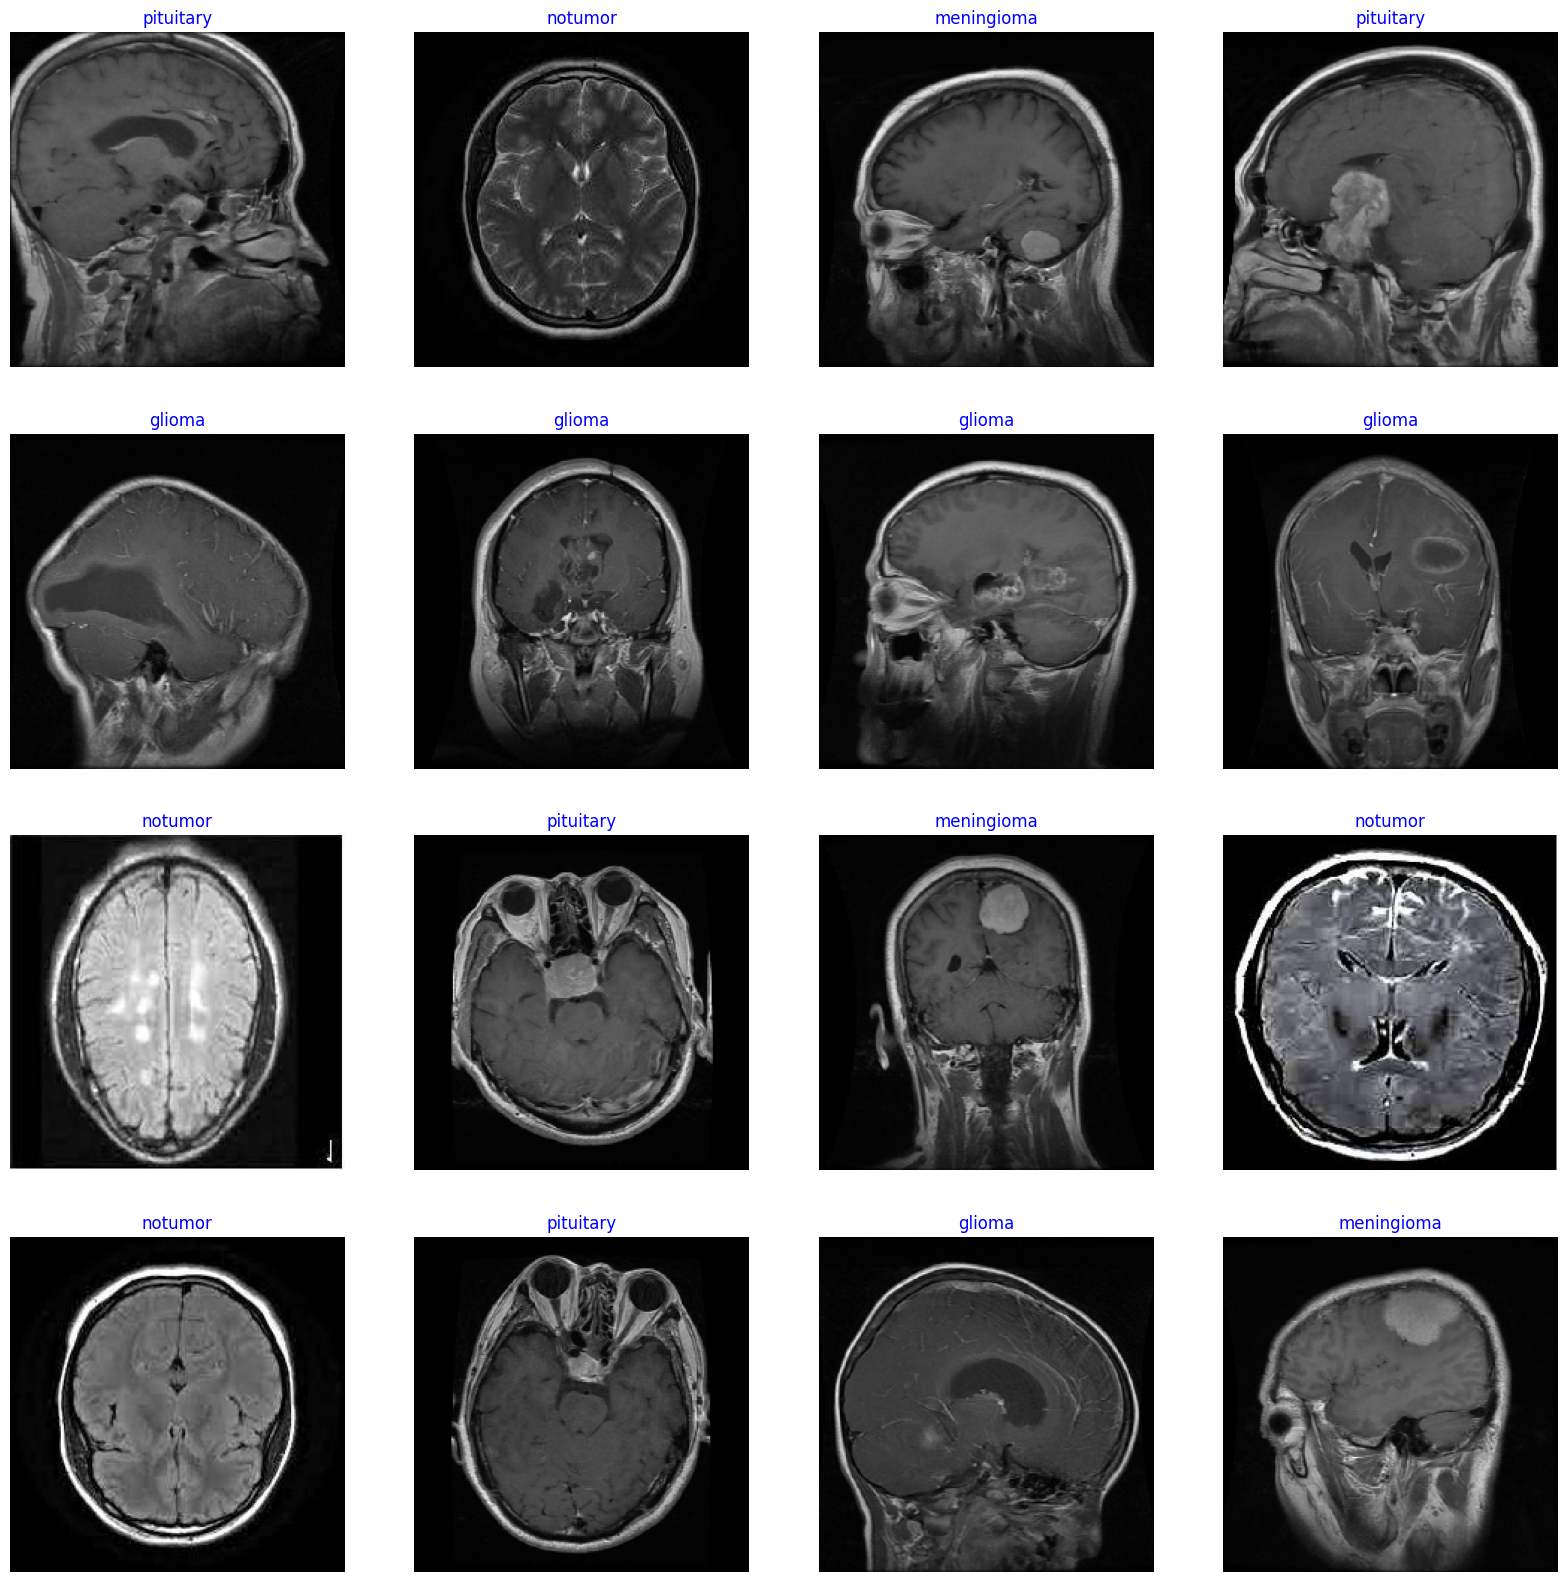

In [8]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

In [9]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
Model: "sequential_1"

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

In [10]:
epochs = 20
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
357/357 [==============================] - 2892s 8s/step - loss: 5.8135 - accuracy: 0.8750 - val_loss: 3.8796 - val_accuracy: 0.9511
Epoch 2/20
357/357 [==============================] - 99s 277ms/step - loss: 2.8811 - accuracy: 0.9506 - val_loss: 1.9863 - val_accuracy: 0.9771
Epoch 3/20
357/357 [==============================] - 101s 282ms/step - loss: 1.5231 - accuracy: 0.9734 - val_loss: 1.0366 - val_accuracy: 0.9924
Epoch 4/20
357/357 [==============================] - 100s 280ms/step - loss: 0.8335 - accuracy: 0.9821 - val_loss: 0.5970 - val_accuracy: 0.9878
Epoch 5/20
357/357 [==============================] - 101s 283ms/step - loss: 0.5049 - accuracy: 0.9862 - val_loss: 0.3719 - val_accuracy: 0.9939
Epoch 6/20
357/357 [==============================] - 100s 281ms/step - loss: 0.3411 - accuracy: 0.9877 - val_loss: 0.2572 - val_accuracy: 0.9939
Epoch 7/20
357/357 [==============================] - 102s 285ms/step - loss: 0.2519 - accuracy: 0.9918 - val_loss: 0.1905 - va

In [12]:
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training Accuracy: 0.9978991746902466
Validation Accuracy: 0.9984732866287231


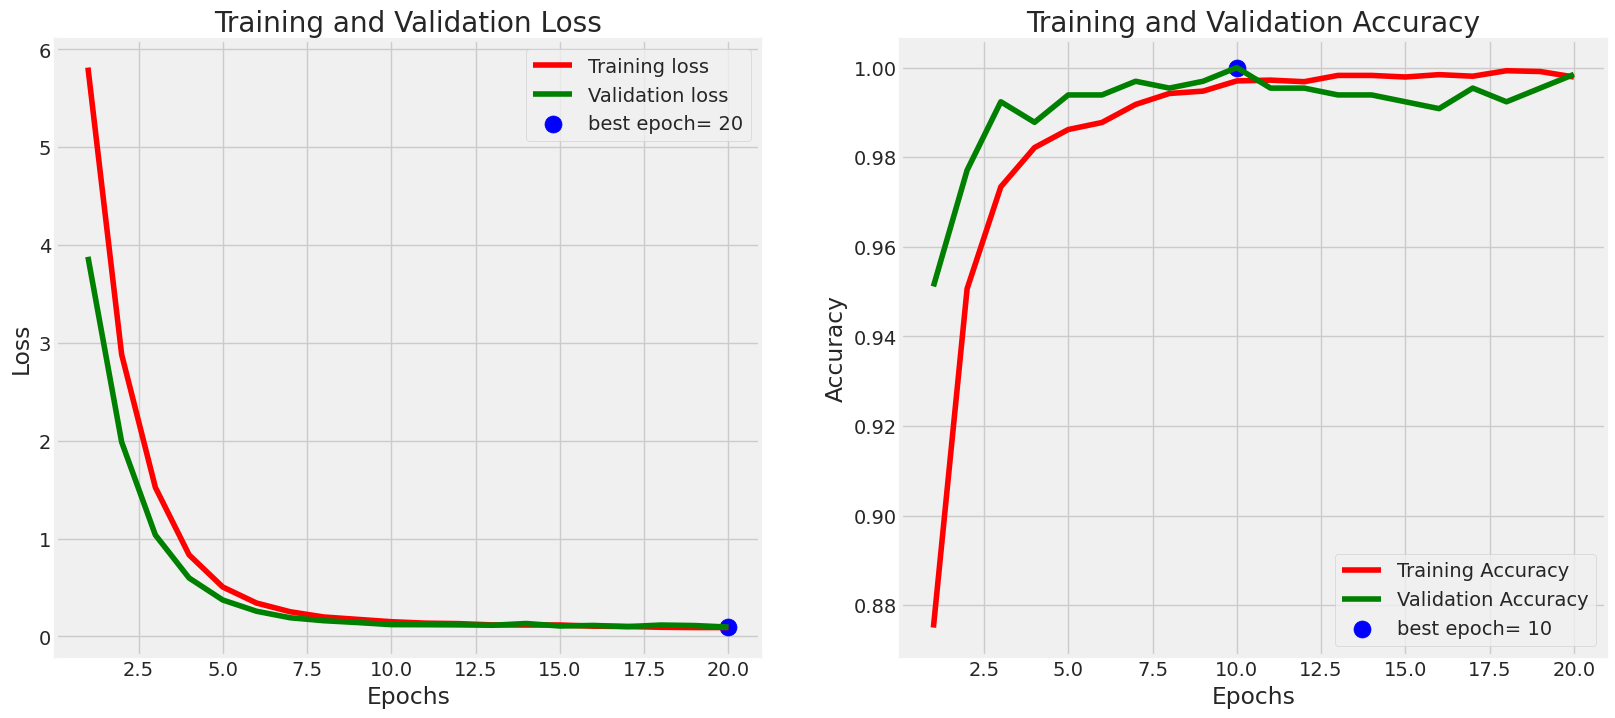

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [14]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

41/41 [==============================] - 241s 6s/step - loss: 0.0959 - accuracy: 0.9970


In [15]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[148,   1,   0,   0],
       [  0, 150,   0,   0],
       [  0,   0, 193,   0],
       [  0,   1,   0, 163]])

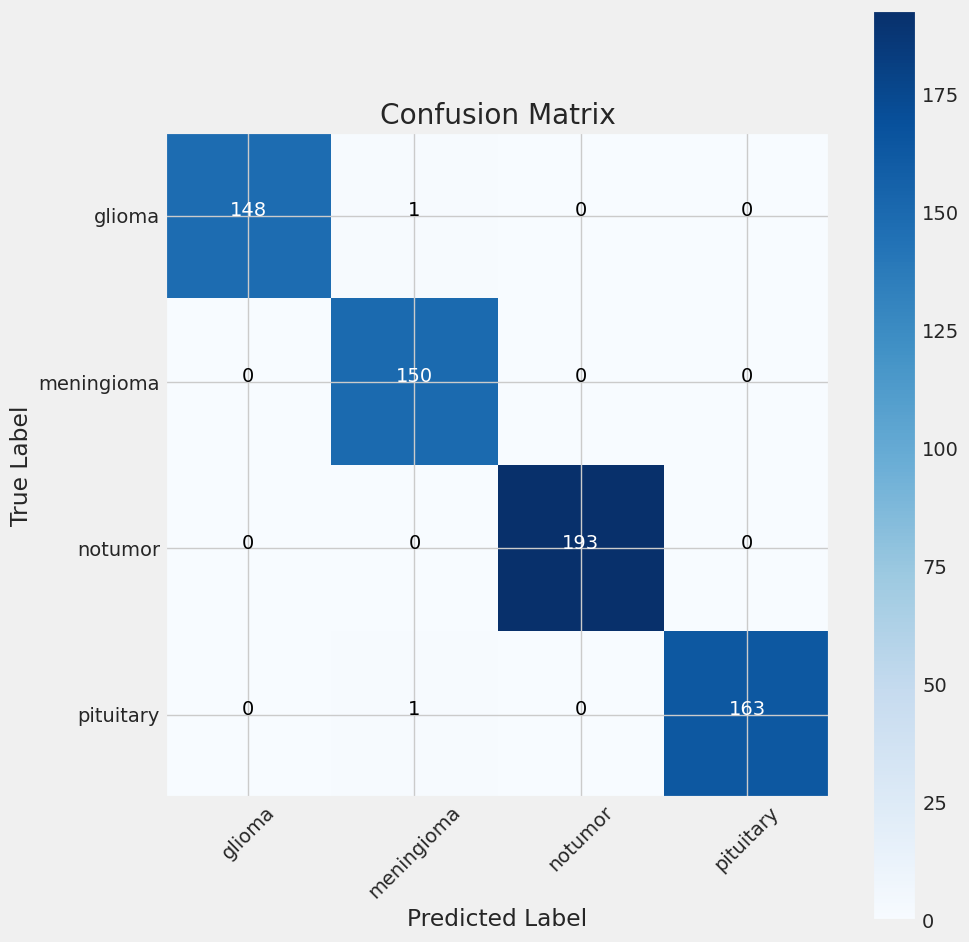

In [17]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [18]:
model.save("Model.h5")